# COVID-19 Clusters Data

The Metro Public Health Department tracks COVID-19 clusters. The files `clusters.csv` and `clusters_by_type.csv` contain the tables of clusters as reported by [WSMV](https://www.wsmv.com/news/metro-health-releases-latest-covid-19-clusters/article_ef554e08-1558-11eb-b290-873345e174d7.html) along with the coordinates of the clusters. Can you find any connection between the reported COVID violations and subsequent COVID clusters?

In [1]:
# import statements
import pandas as pd
import numpy as np
import json
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from cartopy.io import shapereader
%matplotlib inline

In [2]:
# display settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Read in and explore the COVID-19 clusters dataframes

In [3]:
clusters = pd.read_csv('../data/clusters.csv')
clusters.head()

,Cluster Name,Facility Type,Cluster Start Date,# Cases,Latitude,Longitude
0,Vanderbilt Parties,Social Gathering,3/11/2020,49,36.144703,-86.802655
1,Event at Clementine Hall,Social Gathering,3/14/2020,23,36.152444,-86.844583
2,Religious Retreat,Social Gathering,3/25/2020,18,NaN,NaN
3,The Health Center at Richland Place,LTCF,4/3/2020,47,36.128750,-86.817345
4,Trevecca Center for Rehab and Healing,LTCF,4/4/2020,102,36.144562,-86.754560


In [4]:
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cluster Name        62 non-null     object 
 1   Facility Type       62 non-null     object 
 2   Cluster Start Date  62 non-null     object 
 3   # Cases             62 non-null     int64  
 4   Latitude            51 non-null     float64
 5   Longitude           51 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 3.0+ KB


In [5]:
clusters.columns = ['cluster_name', 'type', 'start_date', 'case_count', 'lat', 'long']
clusters.head()

,cluster_name,type,start_date,case_count,lat,long
0,Vanderbilt Parties,Social Gathering,3/11/2020,49,36.144703,-86.802655
1,Event at Clementine Hall,Social Gathering,3/14/2020,23,36.152444,-86.844583
2,Religious Retreat,Social Gathering,3/25/2020,18,NaN,NaN
3,The Health Center at Richland Place,LTCF,4/3/2020,47,36.128750,-86.817345
4,Trevecca Center for Rehab and Healing,LTCF,4/4/2020,102,36.144562,-86.754560


In [6]:
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cluster_name  62 non-null     object 
 1   type          62 non-null     object 
 2   start_date    62 non-null     object 
 3   case_count    62 non-null     int64  
 4   lat           51 non-null     float64
 5   long          51 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 3.0+ KB


In [7]:
# Clean up data types in the clusters dataframe
clusters.start_date = pd.to_datetime(clusters['start_date'], errors = 'raise')
# # Not necessary anymore
# clusters.long = clusters.long.str.replace(',','')
# clusters.long = pd.to_numeric(clusters['long'], errors = 'raise')
# clusters.long.unique()

In [8]:
# Check that the datatypes look good
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cluster_name  62 non-null     object        
 1   type          62 non-null     object        
 2   start_date    62 non-null     datetime64[ns]
 3   case_count    62 non-null     int64         
 4   lat           51 non-null     float64       
 5   long          51 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 3.0+ KB


In [9]:
# What is the smallest cluster?
clusters.case_count.min()

10

In [10]:
# See how many unique clusters are identified 
big_clusters = clusters.type.value_counts().to_frame()
big_clusters

,type
LTCF,20
Congregate Living,8
Bar,6
Social Gathering,6
Correctional Facility,6
Construction,5
Other,3
Commercial-Warehouse,2
School,1
Office,1


In [11]:
big_clusters.reset_index(inplace = True)
big_clusters.columns

Index(['index', 'type'], dtype='object')

In [12]:
big_clusters = big_clusters.rename(columns = {'type' : 'cluster_count', 'index':'type'})
big_clusters.columns

Index(['type', 'cluster_count'], dtype='object')

In [13]:
big_clusters.head()

,type,cluster_count
0,LTCF,20
1,Congregate Living,8
2,Bar,6
3,Social Gathering,6
4,Correctional Facility,6


### Read in the Clusters by Type dataframe

In [14]:
# Since there are no coordinates, just read this in as a normal pandas dataframe
clusters_by_type = pd.read_csv('../data/clusters_by_type.csv')
clusters_by_type.head()

,Cluster Type,Number of Clusters
0,Bar,7
1,Church,2
2,College / University,5
3,Commercial-Warehouse,12
4,Congregate Living,13


In [15]:
clusters_by_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Cluster Type        18 non-null     object
 1   Number of Clusters  18 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 416.0+ bytes


In [16]:
# Update the column names
clusters_by_type.columns = ['type', 'cluster_count']
clusters_by_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   type           18 non-null     object
 1   cluster_count  18 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 416.0+ bytes


In [17]:
# Compare the cluster types in the two dataframes
print(clusters.sort_values('type').type.unique())
print(clusters_by_type.sort_values('type').type.unique())

['Bar' 'Church' 'College / University' 'Commercial-Warehouse'
 'Congregate Living' 'Construction' 'Correctional Facility' 'Gym' 'LTCF'
 'Office' 'Other' 'Restaurant' 'School' 'Social Gathering']
['Bar' 'Church' 'College / University' 'Commercial-Warehouse'
 'Congregate Living' 'Construction' 'Correctional Facility' 'Day Care'
 'Food Production' 'Grocery' 'Gym' 'Healthcare, non-LTCF' 'LTCF' 'Office'
 'Other' 'Restaurant' 'School' 'Social Gathering']


The list looks largely the same, though there are some cluster types that are not represented in the individual `clusters` dataset. Based on my understanding of COVID-19 data aggregation practices and the WSMV statement that only clusters of 10+ individuals are identified, I assume that the clusters represented in the `clusters` dataset are all of those that are `>= 10 cases` to protect the privacy of individuals diagnosed with COVID-19 in small clusters.

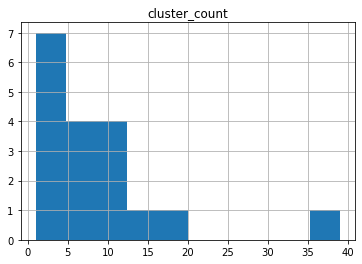

In [18]:
clusters_by_type.hist();

In [19]:
# Which type of facility is the outlier? LTCF
clusters_by_type[clusters_by_type['cluster_count'] > 20]

,type,cluster_count
12,LTCF,39


In [20]:
# Merge the big cluster counts with the clusters_by_type dataframe
clusters_by_type = clusters_by_type.merge(big_clusters, how = 'left', on = 'type', suffixes = ['_total', '_big'])
clusters_by_type

,type,cluster_count_total,cluster_count_big
0,Bar,7,6.0
1,Church,2,1.0
2,College / University,5,1.0
3,Commercial-Warehouse,12,2.0
4,Congregate Living,13,8.0
5,Construction,19,5.0
6,Correctional Facility,9,6.0
7,Day Care,7,NaN
8,Food Production,2,NaN
9,Grocery,1,NaN


In [21]:
# Fill NaN values so that the columns can be mathed
clusters_by_type['cluster_count_big'] = clusters_by_type['cluster_count_big'].fillna(0)

In [22]:
# Create the small cluster count column by subtracting the large clusters from the total
clusters_by_type['cluster_count_small'] = clusters_by_type.cluster_count_total - clusters_by_type.cluster_count_big

In [23]:
# Set all the types to integers
clusters_by_type = clusters_by_type.astype({'cluster_count_big' : 'int64', 'cluster_count_small' : 'int64'})
clusters_by_type = clusters_by_type.sort_values('cluster_count_total', ascending = False)

In [24]:
# Check to make sure it looks good
clusters_by_type.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 12 to 9
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   type                 18 non-null     object
 1   cluster_count_total  18 non-null     int64 
 2   cluster_count_big    18 non-null     int64 
 3   cluster_count_small  18 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 720.0+ bytes


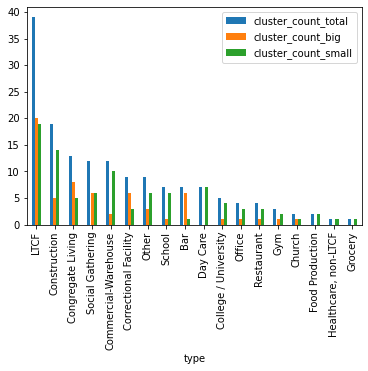

In [25]:
# Create a bar chart here of side-by-side cluster sizes
clusters_by_type.plot(kind = 'bar', x = 'type', y = ['cluster_count_total', 'cluster_count_big', 'cluster_count_small']);

<AxesSubplot:xlabel='start_date'>

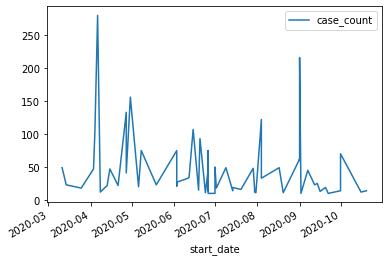

In [26]:
# Create a bar chart of clusters over time
clusters.plot(kind = 'line', x = 'start_date', y = 'case_count')

### Read in the COVID-19 reported violations dataframe

In [27]:
# Since I need to update a couple of items, reading this in first as a pandas dataframe
violations = pd.read_csv('../data/covid_violations.csv')
violations.head()

,request_no,datetime_opened,contact_type,address,city,zip,lat,long,coord
0,346122,04/15/2020 11:33:26 AM,NaN,928 6th Ave S,NASHVILLE,37203.0,36.149040,-86.772273,"(36.1490396, -86.77227289999999)"
1,339374,04/04/2020 06:13:59 PM,NaN,500 Gallatin Ave,NASHVILLE,37206.0,36.181548,-86.749695,"(36.181548, -86.749695)"
2,343513,04/10/2020 10:40:08 AM,NaN,5720 Crossings Blvd,NaN,NaN,36.039608,-86.646541,"(36.039608, -86.646541)"
3,442996,08/12/2020 02:05:29 AM,NaN,7689 Hwy 70 S,NASHVILLE,37221.0,36.078933,-86.953400,"(36.07893290000001, -86.9533998)"
4,339423,04/04/2020 08:12:27 PM,NaN,5310 Mt View Rd,ANTIOCH,37013.0,36.048182,-86.648447,"(36.0481819, -86.6484474)"


In [28]:
violations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11630 entries, 0 to 11629
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   request_no       11630 non-null  int64  
 1   datetime_opened  11630 non-null  object 
 2   contact_type     46 non-null     object 
 3   address          11256 non-null  object 
 4   city             10651 non-null  object 
 5   zip              10716 non-null  float64
 6   lat              11352 non-null  float64
 7   long             11352 non-null  float64
 8   coord            11352 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 817.9+ KB


In [29]:
# Create a new datetime field for the date a violation was reported
violations['date_opened'] = violations['datetime_opened'].str[:10]

In [30]:
# Convert that field into datetime format
violations['date_opened'] = pd.to_datetime(violations['date_opened'], errors = 'raise')

In [31]:
# Check the datatypes
violations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11630 entries, 0 to 11629
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   request_no       11630 non-null  int64         
 1   datetime_opened  11630 non-null  object        
 2   contact_type     46 non-null     object        
 3   address          11256 non-null  object        
 4   city             10651 non-null  object        
 5   zip              10716 non-null  float64       
 6   lat              11352 non-null  float64       
 7   long             11352 non-null  float64       
 8   coord            11352 non-null  object        
 9   date_opened      11630 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 908.7+ KB


In [32]:
# Create a new dataframe with a count of violations by coordinates
violations_by_loc = violations.groupby(['long', 'lat']).count()
# Sort the dataframe and take a look at the top-50 results
violations_by_loc = violations_by_loc.sort_values(['request_no'], ascending = False)
violations_by_loc.head(50)

,,request_no,datetime_opened,contact_type,address,city,zip,coord,date_opened
long,lat,,,,,,,,
-86.782000,36.163000,272,272,1,272,265,265,272,272
-86.774605,36.195731,113,113,0,113,108,108,113,113
-86.782343,36.170861,39,39,0,39,39,39,39,39
-86.774621,36.195585,32,32,0,32,28,28,32,32
-86.778476,36.167262,29,29,0,29,29,29,29,29
-86.787453,36.156583,25,25,0,25,25,25,25,25
-86.776781,36.162544,24,24,0,24,24,24,24,24
-86.747059,36.184381,20,20,0,20,20,20,20,20
-86.651201,36.264297,20,20,0,20,20,20,20,20


In [33]:
violations_by_loc = violations_by_loc.drop(['datetime_opened', 'contact_type', 'address', 'city', 'zip', 'coord', 'date_opened'], axis = 1)

In [34]:
violations_by_loc.reset_index(inplace = True)
violations_by_loc.head()

,long,lat,request_no
0,-86.782000,36.163000,272
1,-86.774605,36.195731,113
2,-86.782343,36.170861,39
3,-86.774621,36.195585,32
4,-86.778476,36.167262,29


In [35]:
violations_by_date = violations.groupby(['date_opened']).count()
# Sort the dataframe and take a look at the top-50 results
violations_by_date = violations_by_date.sort_values(['request_no'], ascending = False)
violations_by_date.head(50)

,request_no,datetime_opened,contact_type,address,city,zip,lat,long,coord
date_opened,,,,,,,,,
2020-04-03,266,266,3,209,188,194,209,209,209
2020-04-02,247,247,2,167,160,174,167,167,167
2020-04-06,219,219,0,218,201,219,219,219,219
2020-04-01,206,206,0,125,114,123,124,124,124
2020-08-02,193,193,0,190,184,184,191,191,191
2020-08-03,171,171,0,171,153,153,171,171,171
2020-04-07,147,147,0,145,137,147,147,147,147
2020-07-02,132,132,1,129,128,128,130,130,130
2020-07-14,130,130,0,126,122,122,128,128,128


In [36]:
violations_by_date.reset_index(inplace = True)
violations_by_date.head()

,date_opened,request_no,datetime_opened,contact_type,address,city,zip,lat,long,coord
0,2020-04-03,266,266,3,209,188,194,209,209,209
1,2020-04-02,247,247,2,167,160,174,167,167,167
2,2020-04-06,219,219,0,218,201,219,219,219,219
3,2020-04-01,206,206,0,125,114,123,124,124,124
4,2020-08-02,193,193,0,190,184,184,191,191,191


In [37]:
violations_by_date = violations_by_date.drop(['datetime_opened', 'contact_type', 'address', 'city', 'zip', 'lat', 'long'], axis = 1)

In [38]:
violations_by_date.head()

,date_opened,request_no,coord
0,2020-04-03,266,209
1,2020-04-02,247,167
2,2020-04-06,219,219
3,2020-04-01,206,124
4,2020-08-02,193,191


In [39]:
violations_by_date.columns = ['date_opened', 'total_violations', 'total_num_w_coords']
violations_by_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date_opened         222 non-null    datetime64[ns]
 1   total_violations    222 non-null    int64         
 2   total_num_w_coords  222 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 5.3 KB


In [40]:
# Create a new dataframe with a count of violations by coordinates
violations_by_loc_and_date = violations.groupby(['long', 'lat', 'date_opened']).count()
# Sort the dataframe and take a look at the top-50 results
violations_by_loc_and_date = violations_by_loc_and_date.sort_values(['request_no'], ascending = False)
violations_by_loc_and_date.head(50)

request_no  datetime_opened  contact_type  address  city  zip  coord
long       lat       date_opened                                                                      
-86.774605 36.195731 2020-08-02           68               68             0       68    67   67     68
                     2020-08-03           33               33             0       33    29   29     33
-86.774621 36.195585 2020-08-02           17               17             0       17    17   17     17
                     2020-08-03           11               11             0       11     7    7     11
-86.782000 36.163000 2020-07-14            9                9             0        9     9    9      9
-86.776781 36.162544 2020-05-21            8                8             0        8     8    8      8
-86.786437 36.153514 2020-04-11            8                8             0        8     8    8      8
-86.711636 36.127215 2020-06-27            7                7             0        7     7    7      7
-86.782000 36.163000 2020-07-18            6                6             0        6     6    6      6
-86.776765 36.162282 2020-05-21            6                6             0        6     6    6      6
-86.924964 36.072731 2020-10-16            6                6             0        6     6    6      6
-86.699898 36.296005 2020-04-01            6                6             0        6     6    6      6
-86.790527 36.153047 2020-08-05            6                6             0        6     6    6      6
-86.775726 36.161446 2020-06-13            5                5             0        5     5    5      5
-86.782000 36.163000 2020-07-20            5                5             0        5     5    5      5
-86.790527 36.153047 2020-08-04            5                5             0        5     5    5      5
-86.776781 36.162544 2020-05-20            5                5             0        5     5    5      5
-86.782000 36.163000 2020-04-22            5                5             0        5     5    5      5
                     2020-07-04            5                5             0        5     5    5      5
                     2020-05-05            5                5             0        5     5    5      5
-86.803206 36.235362 2020-10-26            5                5             0        5     5    5      5
-86.777727 36.167608 2020-10-12            5                5             0        5     5    5      5
-86.782000 36.163000 2020-04-08            5                5             0        5     5    5      5
                     2020-04-05            5                5             0        5     5    5      5
-86.977050 36.062514 2020-04-06            4                4             0        4     4    4      4
-86.624020 36.018810 2020-05-05            4                4             0        4     4    4      4
-86.789934 36.153189 2020-06-22            4                4             0        4     4    4      4
-86.782343 36.170861 2020-09-11            4                4             0        4     4    4      4
-86.781891 36.197270 2020-08-02            4                4             0        4     3    3      4
-86.775726 36.161446 2020-06-14            4                4             0        4     3    3      4
-86.778126 36.166611 2020-10-12            4                4             0        4     4    4      4
-86.787453 36.156583 2020-07-19            4                4             0        4     4    4      4
-86.917717 36.133598 2020-07-07            4                4             0        4     4    4      4
-86.777385 36.195817 2020-08-02            4                4             0        4     4    4      4
-86.619672 36.199056 2020-04-02            4                4             0        4     3    4      4
-86.778476 36.167262 2020-09-17            4                4             0        4     4    4      4
                     2020-09-18            4                4             0        4     4    4      4
                 

In [41]:
violations_by_loc_and_date = violations_by_loc_and_date.drop(['datetime_opened', 'contact_type', 'address', 'city', 'zip', 'coord'], axis = 1)

In [42]:
violations_by_loc_and_date.reset_index(inplace = True)
violations_by_loc_and_date.head()

,long,lat,date_opened,request_no
0,-86.774605,36.195731,2020-08-02,68
1,-86.774605,36.195731,2020-08-03,33
2,-86.774621,36.195585,2020-08-02,17
3,-86.774621,36.195585,2020-08-03,11
4,-86.782000,36.163000,2020-07-14,9


In [43]:
# Check out the coordinates that have 15 violations but only 3 locations
violations[violations['coord'] == '(36.15658331160417, -86.78745279999998)']

,request_no,datetime_opened,contact_type,address,city,zip,lat,long,coord,date_opened
154,407584,07/04/2020 03:21:22 PM,NaN,NaN,NASHVILLE,37203.0,36.156583,-86.787453,"(36.15658331160417, -86.78745279999998)",2020-07-04
256,371422,05/19/2020 12:51:30 PM,NaN,NaN,NASHVILLE,37203.0,36.156583,-86.787453,"(36.15658331160417, -86.78745279999998)",2020-05-19
3466,426346,07/25/2020 01:34:33 AM,NaN,NaN,NASHVILLE,37203.0,36.156583,-86.787453,"(36.15658331160417, -86.78745279999998)",2020-07-25
3685,435255,08/01/2020 11:45:05 PM,NaN,NaN,NASHVILLE,37203.0,36.156583,-86.787453,"(36.15658331160417, -86.78745279999998)",2020-08-01
5751,392946,06/16/2020 02:37:13 AM,NaN,NaN,NASHVILLE,37203.0,36.156583,-86.787453,"(36.15658331160417, -86.78745279999998)",2020-06-16
6000,422255,07/21/2020 05:49:58 PM,NaN,NaN,NASHVILLE,37203.0,36.156583,-86.787453,"(36.15658331160417, -86.78745279999998)",2020-07-21
6814,414143,07/12/2020 05:22:15 AM,NaN,NaN,NASHVILLE,37203.0,36.156583,-86.787453,"(36.15658331160417, -86.78745279999998)",2020-07-12
7134,413993,07/11/2020 06:03:58 PM,NaN,NaN,NASHVILLE,37203.0,36.156583,-86.787453,"(36.15658331160417, -86.78745279999998)",2020-07-11
7442,407505,07/04/2020 04:13:40 AM,NaN,NaN,NASHVILLE,37203.0,36.156583,-86.787453,"(36.15658331160417, -86.78745279999998)",2020-07-04
7478,407502,07/04/2020 03:55:16 AM,NaN,NaN,NASHVILLE,37203.0,36.156583,-86.787453,"(36.15658331160417, -86.78745279999998)",2020-07-04


_These all appear to be generic 'Broadway' references. Probably best to just use coordinates to map items, so I went back and removed all of the street address info above to make the data a bit easier to work with._

### Read in a base map of Davidson County, parsed by zipcode

In [44]:
davidson = gpd.read_file('../data/zipcodes.geojson')
print(davidson.crs)
davidson.head()

epsg:4326


,zip,objectid,po_name,shape_stlength,shape_starea,geometry
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ..."
1,37216,3,NASHVILLE,75820.997821400058,188884682.28344727,"MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ..."
2,37204,9,NASHVILLE,93180.292250425613,200664795.51708984,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ..."
3,37027,11,BRENTWOOD,159760.6942933173,174978422.04101562,"MULTIPOLYGON (((-86.81258 36.06319, -86.81263 ..."
4,37064,18,FRANKLIN,28995.828320601937,46969608.005737305,"MULTIPOLYGON (((-87.02197 36.01200, -87.02140 ..."


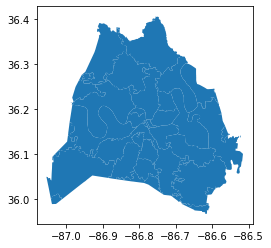

In [45]:
davidson.plot();

### Create some geo dataframes to map things

In [46]:
# Create a geopandas dataframe based on the violations data, grouped by location
violations_by_loc_geo = gpd.GeoDataFrame(
    violations_by_loc, crs = davidson.crs, geometry = gpd.points_from_xy(violations_by_loc.long, violations_by_loc.lat))

# Make sure it worked
violations_by_loc_geo.head()

,long,lat,request_no,geometry
0,-86.782000,36.163000,272,POINT (-86.78200 36.16300)
1,-86.774605,36.195731,113,POINT (-86.77461 36.19573)
2,-86.782343,36.170861,39,POINT (-86.78234 36.17086)
3,-86.774621,36.195585,32,POINT (-86.77462 36.19558)
4,-86.778476,36.167262,29,POINT (-86.77848 36.16726)


In [47]:
# # Create a geopandas dataframe based on the violations data, grouped by location
# violations_geo = gpd.GeoDataFrame(
#     violations, geometry = gpd.points_from_xy(violations.long, violations.lat))

# # Make sure it worked
# violations_geo.head()

In [48]:
# If using the full violations dataset
# violations_geo = violations_geo.drop(['datetime_opened', 'address', 'city', 'zip', 'lat', 'long', 'coord'], axis = 1)

In [49]:
# # Set the CRS
# violations_geo = violations_geo.set_crs(epsg=4326)
# print(violations_geo.crs)

In [50]:
# violations_geo.info()

In [51]:
# Create a geopandas dataframe based on the cleaned-up clusters dataframe
clusters_geo = gpd.GeoDataFrame(
    clusters, crs = davidson.crs, geometry = gpd.points_from_xy(clusters.long, clusters.lat))

# Make sure it worked
clusters_geo.head()

,cluster_name,type,start_date,case_count,lat,long,geometry
0,Vanderbilt Parties,Social Gathering,2020-03-11,49,36.144703,-86.802655,POINT (-86.80266 36.14470)
1,Event at Clementine Hall,Social Gathering,2020-03-14,23,36.152444,-86.844583,POINT (-86.84458 36.15244)
2,Religious Retreat,Social Gathering,2020-03-25,18,NaN,NaN,POINT (nan nan)
3,The Health Center at Richland Place,LTCF,2020-04-03,47,36.128750,-86.817345,POINT (-86.81734 36.12875)
4,Trevecca Center for Rehab and Healing,LTCF,2020-04-04,102,36.144562,-86.754560,POINT (-86.75456 36.14456)


In [52]:
clusters_geo = clusters_geo.drop(['lat', 'long'], axis = 1)

In [53]:
clusters_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cluster_name  62 non-null     object        
 1   type          62 non-null     object        
 2   start_date    62 non-null     datetime64[ns]
 3   case_count    62 non-null     int64         
 4   geometry      62 non-null     geometry      
dtypes: datetime64[ns](1), geometry(1), int64(1), object(2)
memory usage: 2.5+ KB


In [54]:
# Join the clusters and violations data to the base map of Davidson County
violations_by_zip = gpd.sjoin(violations_by_loc_geo, davidson, op = 'within')

In [55]:
violations_by_zip.head()

,long,lat,request_no,geometry,index_right,zip,objectid,po_name,shape_stlength,shape_starea
0,-86.782000,36.163000,272,POINT (-86.78200 36.16300),24,37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
20,-86.781602,36.162664,13,POINT (-86.78160 36.16266),24,37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
42,-86.780408,36.164083,10,POINT (-86.78041 36.16408),24,37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
55,-86.778967,36.164202,8,POINT (-86.77897 36.16420),24,37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
72,-86.781618,36.163828,7,POINT (-86.78162 36.16383),24,37219,15,NASHVILLE,21013.192337432083,6579013.4385986328


In [56]:
# Quick cleanup
violations_by_zip = violations_by_zip.rename(columns = {'request_no' : 'total_violations'})
violations_by_zip = violations_by_zip.drop('index_right', axis = 1)
violations_by_zip.head()

,long,lat,total_violations,geometry,zip,objectid,po_name,shape_stlength,shape_starea
0,-86.782000,36.163000,272,POINT (-86.78200 36.16300),37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
20,-86.781602,36.162664,13,POINT (-86.78160 36.16266),37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
42,-86.780408,36.164083,10,POINT (-86.78041 36.16408),37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
55,-86.778967,36.164202,8,POINT (-86.77897 36.16420),37219,15,NASHVILLE,21013.192337432083,6579013.4385986328
72,-86.781618,36.163828,7,POINT (-86.78162 36.16383),37219,15,NASHVILLE,21013.192337432083,6579013.4385986328


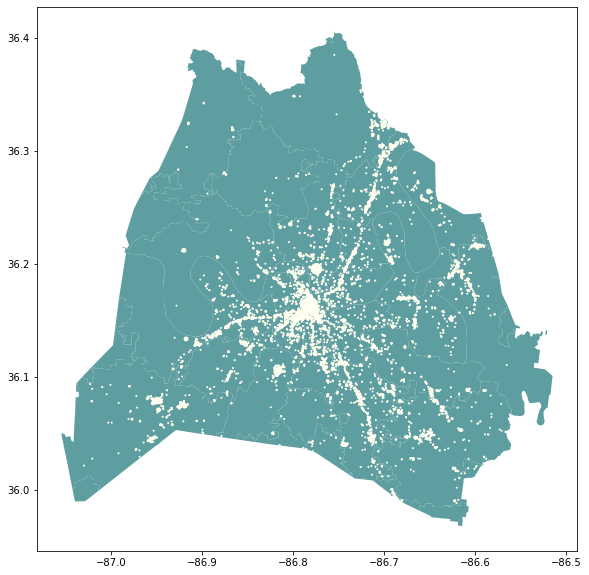

In [57]:
ax = davidson.plot(figsize = (10, 10), color = 'cadetblue')
violations_by_zip.plot(ax = ax, markersize = violations_by_zip['total_violations'], color = 'ivory');

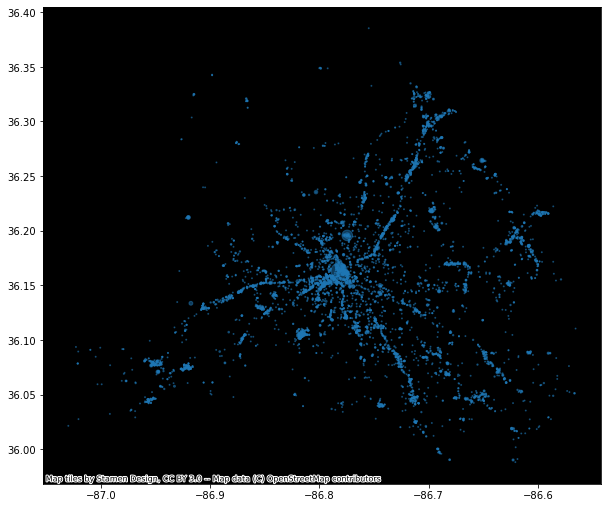

In [58]:
# Another attempt to get a decent basemap
ax = violations_by_zip.plot(figsize = (10, 10), alpha = 0.5, markersize = violations_by_zip['total_violations'])
ctx.add_basemap(ax, source = ctx.providers.Stamen.Toner, zoom = 12)

In [59]:
# Let's try folium
covid_map = folium.Map(
    location=[36.1627, -86.7816],
    tiles='Stamen Toner',
    zoom_start=11
)

In [60]:
# # DON'T RUN ME, I WILL CRASH THE NOTEBOOK
# for row_index, row_values in violations_by_zip.iterrows():
#     loc = [row_values['lat'], row_values['long']]
#     pop = str(row_values['total_violations'])
#     marker = folium.Marker(
#         location = loc, 
#         popup = pop) 
    
#     marker.add_to(covid_map)
# covid_map.save('..covid_map.html')

# #display the map
# covid_map

In [61]:
clusters_by_zip = gpd.sjoin(clusters_geo, davidson, op = 'within')
clusters_by_zip.head()

,cluster_name,type,start_date,case_count,geometry,index_right,zip,objectid,po_name,shape_stlength,shape_starea
0,Vanderbilt Parties,Social Gathering,2020-03-11,49,POINT (-86.80266 36.14470),39,37240,36,NASHVILLE,7052.8091646713856,2841889.5506591797
1,Event at Clementine Hall,Social Gathering,2020-03-14,23,POINT (-86.84458 36.15244),12,37209,10,NASHVILLE,310224.91345860378,1001364029.2892456
48,Lois DeBerry Special Needs Facility,Correctional Facility,2020-09-01,62,POINT (-86.90004 36.19093),12,37209,10,NASHVILLE,310224.91345860378,1001364029.2892456
49,Riverbend Max Security Prison-2,Correctional Facility,2020-09-01,60,POINT (-86.89721 36.17984),12,37209,10,NASHVILLE,310224.91345860378,1001364029.2892456
3,The Health Center at Richland Place,LTCF,2020-04-03,47,POINT (-86.81734 36.12875),32,37205,16,NASHVILLE,146801.80831498865,400978073.00933838


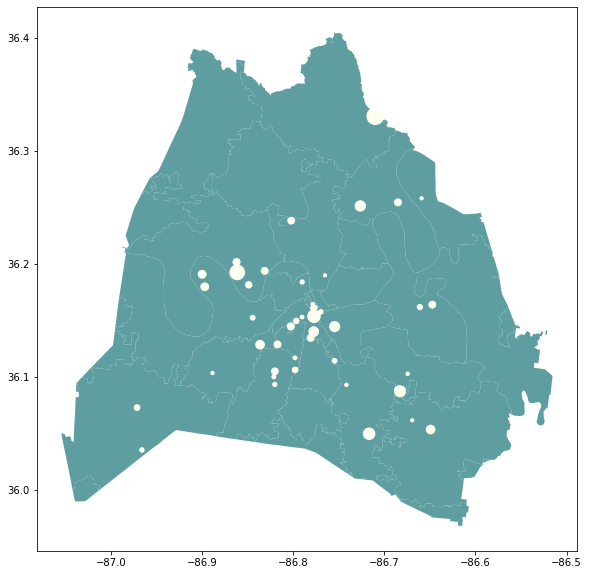

In [62]:
ax = davidson.plot(figsize = (10, 10), color = 'cadetblue')
clusters_by_zip.plot(ax = ax, markersize = clusters_by_zip['case_count'], color = 'ivory');

### Join the two maps together

In [63]:
clusters_and_violations_geo = clusters_by_zip.append(violations_by_zip)
clusters_and_violations_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7423 entries, 0 to 7749
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   cluster_name      51 non-null     object        
 1   type              51 non-null     object        
 2   start_date        51 non-null     datetime64[ns]
 3   case_count        51 non-null     float64       
 4   geometry          7423 non-null   geometry      
 5   index_right       51 non-null     float64       
 6   zip               7423 non-null   object        
 7   objectid          7423 non-null   object        
 8   po_name           7423 non-null   object        
 9   shape_stlength    7423 non-null   object        
 10  shape_starea      7423 non-null   object        
 11  long              7372 non-null   float64       
 12  lat               7372 non-null   float64       
 13  total_violations  7372 non-null   float64       
dtypes: datetime64[ns

In [64]:
clusters_and_violations_geo.head()

,cluster_name,type,start_date,case_count,geometry,index_right,zip,objectid,po_name,shape_stlength,shape_starea,long,lat,total_violations
0,Vanderbilt Parties,Social Gathering,2020-03-11,49.0,POINT (-86.80266 36.14470),39.0,37240,36,NASHVILLE,7052.8091646713856,2841889.5506591797,NaN,NaN,NaN
1,Event at Clementine Hall,Social Gathering,2020-03-14,23.0,POINT (-86.84458 36.15244),12.0,37209,10,NASHVILLE,310224.91345860378,1001364029.2892456,NaN,NaN,NaN
48,Lois DeBerry Special Needs Facility,Correctional Facility,2020-09-01,62.0,POINT (-86.90004 36.19093),12.0,37209,10,NASHVILLE,310224.91345860378,1001364029.2892456,NaN,NaN,NaN
49,Riverbend Max Security Prison-2,Correctional Facility,2020-09-01,60.0,POINT (-86.89721 36.17984),12.0,37209,10,NASHVILLE,310224.91345860378,1001364029.2892456,NaN,NaN,NaN
3,The Health Center at Richland Place,LTCF,2020-04-03,47.0,POINT (-86.81734 36.12875),32.0,37205,16,NASHVILLE,146801.80831498865,400978073.00933838,NaN,NaN,NaN


IndexError: index 2 is out of bounds for axis 0 with size 2

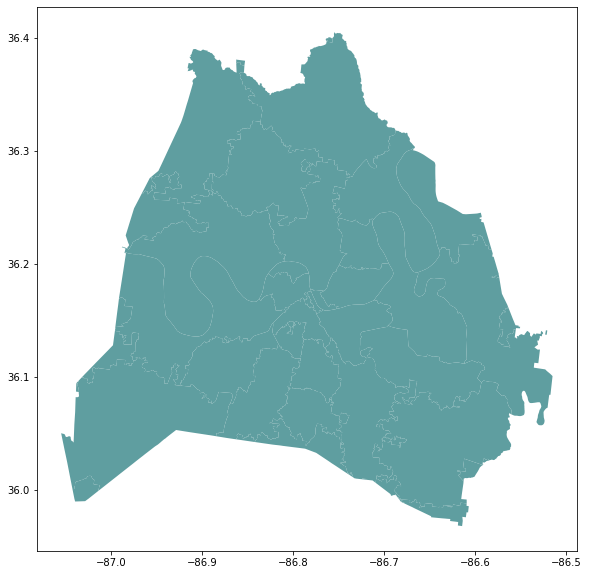

In [65]:
ax = davidson.plot(figsize = (10, 10), color = 'cadetblue')
clusters_and_violations_geo.plot(ax = ax, markersize = ['case_count', 'total_violations'], color = ['ivory', 'red']);